In [2]:
import json

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

base_path_results: str = '/Users/nicolahorst/Documents/GitHub/clem-project_playpen/benchmark_results/clembench/final_models'

base_model_llama_8B: str = 'Unsloth-meta-llama-3.1-4bit-plain-t0.0--Unsloth-meta-llama-3.1-4bit-plain-t0.0'
final_model_llama_8B: str = 'llama3.1-8B-sft-e1-DFINAL_0.7K-steps-t0.0--llama3.1-8B-sft-e1-DFINAL_0.7K-steps-t0.0'
base_model_llama_70B: str = 'Unsloth-meta-llama-3.1-70B-bnb-4bit-t0.0--Unsloth-meta-llama-3.1-70B-bnb-4bit-t0.0'
base_model_metal_llama_70B: str = 'Meta-Llama-3.1-70B-Instruct-t0.0--Meta-Llama-3.1-70B-Instruct-t0.0'


final_model_llama_70B: str = 'llama3.1-70B-sft-e1-DFINAL_0.6K-steps-t0.0--llama3.1-70B-sft-e1-DFINAL_0.6K-steps-t0.0'
base_model_mistral: str = 'Unsloth-Mistral-Small-24B-Instruct-2501-t0.0--Unsloth-Mistral-Small-24B-Instruct-2501-t0.0'
final_model_mistral: str = 'Mistral-small-2501-DFINAL_0.6K-steps-t0.0--Mistral-small-2501-DFINAL_0.6K-steps-t0.0'

std_cols: list = ['game', 'model', 'experiment', 'episode']
model_files: list[str] = ['llama_8B', 'llama_70B', 'mistral']


In [3]:
def load_raw_csv(mode_file: str, base_model: str, final_model: str, game: str) -> pd.DataFrame:
    path: str = base_path_results + '/' + mode_file + '/' + raw_csv
    df = pd.read_csv(path)
    df.drop(columns=['Unnamed: 0'], inplace=True)
    df.metric = df.metric.astype('string')
    df.value = df.value.astype('string')
    #df = df[df['game'] == game]
    metrics_for_game_df = df[df.game == game]
    unique_metrics: list = list(metrics_for_game_df['metric'].unique())
    df_pivoted = group_raw_csv(df, base_model, final_model)

    return reduce_to_metrics_for_game(df_pivoted, unique_metrics)

def group_raw_csv(df: pd.DataFrame, bm, fm) -> pd.DataFrame:
    df_pivoted = df.pivot(index=['game', 'model', 'experiment', 'episode'],
                          columns='metric',
                          values='value')

    # Reset the index to make the index columns regular columns
    df_pivoted = df_pivoted.reset_index()
    return df_pivoted

def reduce_to_metrics_for_game(df: pd.DataFrame, columns_to_keep) -> pd.DataFrame:
    std_cols: list = ['game', 'model', 'experiment', 'episode']
    columns_to_keep = std_cols + columns_to_keep
    columns_to_drop = [ c for c in list(df.columns) if c not in columns_to_keep]
    return df.drop(columns=columns_to_drop, axis=1)

In [4]:
current_game = "adventuregame"
raw_csv= "raw.csv"
columns_to_keep: list = ['game', 'model', 'experiment', 'episode', 'Success', 'Lose', 'Aborted']

df_mistral_raw = load_raw_csv("mistral" ,"", "", current_game)[columns_to_keep]
df_llama8B_raw = load_raw_csv("llama_8B" ,"", "", current_game)[columns_to_keep]
df_llama70B_raw = load_raw_csv("llama_70B"  ,"", "", current_game)[columns_to_keep]

for col in df_llama8B_raw.columns:
    if col not in std_cols:
        df_mistral_raw[col] = pd.to_numeric(df_mistral_raw[col], errors='coerce')
        df_llama8B_raw[col] = pd.to_numeric(df_llama8B_raw[col], errors='coerce')
        df_llama70B_raw[col] = pd.to_numeric(df_llama70B_raw[col], errors='coerce')

# fill success lost abort with 0
df_mistral_raw.fillna(0)
df_llama8B_raw.fillna(0)
df_llama70B_raw.fillna(0)

clean_csv_data = pd.concat([df_mistral_raw, df_llama8B_raw, df_llama70B_raw])

In [5]:
clean_csv_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12198 entries, 0 to 3267
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   game        12198 non-null  object 
 1   model       12198 non-null  object 
 2   experiment  12198 non-null  object 
 3   episode     12198 non-null  object 
 4   Success     11955 non-null  Float64
 5   Lose        11955 non-null  Float64
 6   Aborted     12198 non-null  Float64
dtypes: Float64(3), object(4)
memory usage: 798.1+ KB


s# utils to prepare the labels

In [6]:
# this works for taboo, and all wordle games
def get_term_from_episode(row):
    model_name = row['model']
    game = row['game']
    experiment = row['experiment']
    episode = row['episode']
    
    path: str = f'../../benchmark_results/{model_name}/{game}/{experiment}/{episode}/instance.json'
    instance: dict = json.load(open(path))
    return instance['target_word']

# this works for image game and referencegame and private shared
def get_generic_turn_name(row):
    experiment_name = row['experiment']
    episode = row['episode']
    return f'{experiment_name[2:]}-{episode.split("_")[1]}'

def prepare_model_names(raw_names: list) -> list:
    return [m.split("--")[0].split("-t0")[0] for m in raw_names]

def prepare_value(row):
    if row['Success'] == 1.0: return 'Success'
    if row['Lose'] == 1.0: return 'Loss'
    if row['Aborted'] == 1.0: return 'Aborted'
    return 'Undefined'

def prepare_model_data(model_name, data_frame: pd.DataFrame, get_turn_name) -> pd.DataFrame:
    df: pd.DataFrame = data_frame[data_frame.model == model_name]
    data_base_model: dict = {}
    
    for index, row in df.iterrows():
        data_base_model.update({get_turn_name(row): prepare_value(row)})
        
    return data_base_model


def reorder_columns(df: pd.DataFrame) -> pd.DataFrame:
    original_columns = df.columns.tolist()
    running_columns = df.columns.tolist()
    rearranged_columns = []

    ## collect all values that are aborted
    for column in running_columns:
        if len(df[column].unique()) == 1 and df[column].iloc[0] == 'Aborted':
            rearranged_columns.append(column)

    running_columns = [r for r in running_columns if r not in rearranged_columns]

    ## collect all values that are aborted
    for column in running_columns:
        if df[column].iloc[0] == 'Aborted':
            rearranged_columns.append(column)

    running_columns = [r for r in running_columns if r not in rearranged_columns]

    for column in running_columns:
        if len(df[column].unique()) == 1 and df[column].iloc[0] == 'Loss':
            rearranged_columns.append(column)

    running_columns = [r for r in running_columns if r not in rearranged_columns]

    for column in running_columns:
        if df[column].iloc[0] == 'Loss':
            rearranged_columns.append(column)

    running_columns = [r for r in running_columns if r not in rearranged_columns]

    for column in running_columns:
        if len(df[column].unique()) == 1 and df[column].iloc[0] == 'Success':
            rearranged_columns.append(column)

    running_columns = [r for r in running_columns if r not in rearranged_columns]

    for column in running_columns:
        if df[column].iloc[0] == 'Success':
            rearranged_columns.append(column)

    assert len(rearranged_columns) == len(original_columns)

    return rearranged_columns, original_columns

In [7]:
# list of all games
games = list(set(list(clean_csv_data.game)))

# only consider these models for eval
models_to_consider: list = [base_model_llama_8B, final_model_llama_8B]

turn_extraction_lookup = {
    'wordle': get_generic_turn_name, # get_term_from_episode,
    'wordle_withclue': get_generic_turn_name, #get_term_from_episode,
    'wordle_withcritic': get_generic_turn_name, #get_term_from_episode,
    'taboo': get_generic_turn_name, #get_term_from_episode,
    'imagegame': get_generic_turn_name,
    'referencegame': get_generic_turn_name,
    'privateshared': get_generic_turn_name,
    "adventuregame": get_generic_turn_name,
    "codenames": get_generic_turn_name,
    "textmapworld": get_generic_turn_name,
    "textmapworld_specificroom": get_generic_turn_name,
    "textmapworld_graphreasoning": get_generic_turn_name,
    "guesswhat": get_generic_turn_name,
    "matchit_ascii": get_generic_turn_name
}

custom_height_lookup = {
    'wordle': 3,
    'wordle_withclue': 3,
    'wordle_withcritic': 3,
    'taboo': 3.7,
    'imagegame': 3.8,
    'referencegame': 5,
    'privateshared': 3.7,
    "adventuregame": 3.8,
    "codenames": 3.8,
    "textmapworld": 3.8,
    "textmapworld_specificroom": 3.8,
    "textmapworld_graphreasoning": 3.8,
    "guesswhat": 3.8,
    "matchit_ascii": 2.5
}

custom_width_lookup = {
    'wordle': 11,
    'wordle_withclue': 11,
    'wordle_withcritic': 11,
    'taboo': 15,
    'imagegame': 11,
    'referencegame': 30,
    'privateshared': 15,
    "adventuregame": 15,
    "codenames": 15,
    "textmapworld": 15,
    "textmapworld_specificroom": 15,
    "textmapworld_graphreasoning": 15,
    "guesswhat": 15,
    "matchit_ascii": 15
}
games

['textmapworld',
 'adventuregame',
 'matchit_ascii',
 'guesswhat',
 'codenames',
 'privateshared',
 'imagegame',
 'textmapworld_specificroom',
 'wordle_withcritic',
 'taboo',
 'wordle',
 'textmapworld_graphreasoning',
 'referencegame',
 'wordle_withclue']

## Set up the plotting

/var/folders/rp/55m2cs9j4nq0zsmq1sdq68kw0000gn/T/ipykernel_42238/875452613.py:55: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


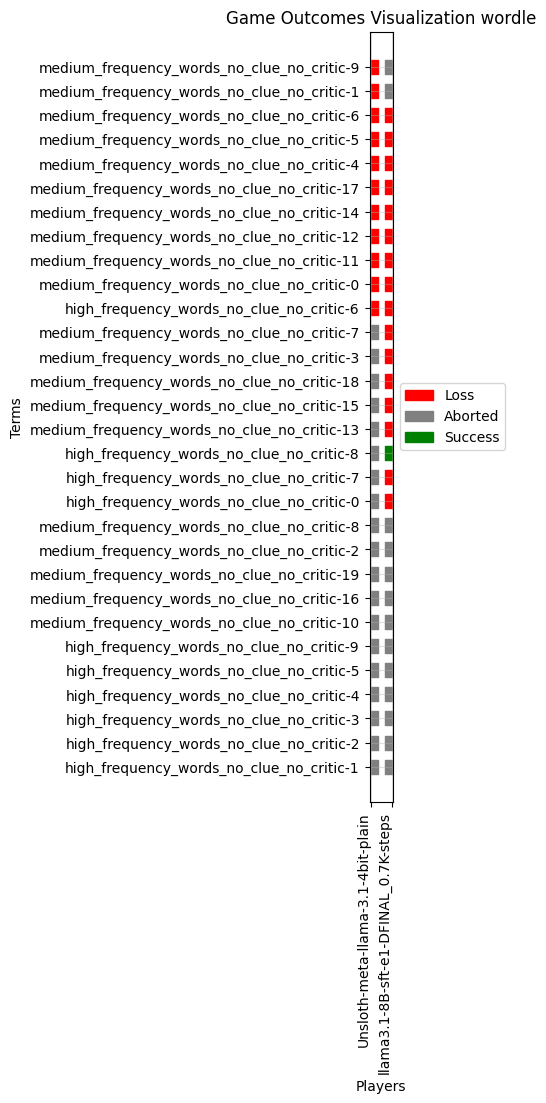

In [8]:
for game in ['wordle']:
    game_data = clean_csv_data[clean_csv_data.game == game]

    plot_data: dict = {}
    for model_name, short_name in zip(models_to_consider, prepare_model_names(models_to_consider)):
        prep_data = prepare_model_data(model_name, game_data, turn_extraction_lookup[game])
        plot_data.update({short_name: prep_data})
    
    
    df = pd.DataFrame(plot_data)
    df_transposed = df.T
    
    reordered_columns, original_columns = reorder_columns(df_transposed)
    df_reordered = df_transposed[reordered_columns].T

    # Sample data
    players = prepare_model_names(models_to_consider)
    terms = list(df_reordered.index)
    
    # Create a dictionary to map outcomes to colors
    color_map = {'Success': 'green', 'Loss': 'red', 'Aborted': 'gray', 'Undefined': 'lightblue'}
    
    # Sample data structure (replace with your actual data)
    data = df_reordered
    
    # Set up the plot
    fig, ax = plt.subplots(figsize=(0.3, 10))

    for i, player in enumerate(players):
        for j, term in enumerate(terms):
            outcome = data[player][term]
            ax.scatter(i, j, color=color_map[outcome], s=100, marker='s')

    ax.set_xticks(range(len(players)))
    ax.set_xticklabels(players, rotation=90, ha='right')
    ax.set_yticks(range(len(terms)))
    ax.set_yticklabels(terms)
    ax.set_xlabel('Players')
    ax.set_ylabel('Terms')

    ax.set_title(f'Game Outcomes Visualization {game}')
    
    # Add a grid for better readability
    ax.grid(True, linestyle='-', alpha=0.4)
    
    
    # Creating legend with color box
    color_box_loss = mpatches.Patch(color='red', label='Loss')
    color_box_aborted = mpatches.Patch(color='gray', label='Aborted')
    color_box_success = mpatches.Patch(color='green', label='Success')
    
    plt.legend(handles=[color_box_loss, color_box_aborted, color_box_success],loc='center left', bbox_to_anchor=(1, 0.5))
    
    
    plt.tight_layout()
    plt.savefig(f'../../plots/success_abort_rate_{game}.png')
    plt.show()

In [9]:
#df_baseline = clean_csv_data[clean_csv_data.model == base_model_name]
def mapLostToAborted(row, baseline_df):
    game = row['game']
    experiment = row['experiment']
    episode = row['episode']

    basline_loss = baseline_df[(baseline_df['game'] == game) &
                               (baseline_df['experiment'] == experiment) &
                               (baseline_df['episode'] == episode)]['Lose'].iloc[0]  # Get the scalar value

    if basline_loss == 1 and row['Aborted'] == 1:
        return 1

    return 0

def mapSuccessToAborted(row, baseline_df):
    game = row['game']
    experiment = row['experiment']
    episode = row['episode']

    basline_loss = baseline_df[(baseline_df['game'] == game) &
                               (baseline_df['experiment'] == experiment) &
                               (baseline_df['episode'] == episode)]['Success'].iloc[0]  # Get the scalar value

    if basline_loss == 1 and row['Aborted'] == 1:
        return 1

    return 0

def mapSuccessToLost(row, baseline_df):
    game = row['game']
    experiment = row['experiment']
    episode = row['episode']

    basline_loss = baseline_df[(baseline_df['game'] == game) &
                               (baseline_df['experiment'] == experiment) &
                               (baseline_df['episode'] == episode)]['Success'].iloc[0]  # Get the scalar value

    if basline_loss == 1 and row['Lose'] == 1:
        return 1

    return 0

def mapLostToSuccess(row, baseline_df):
    game = row['game']
    experiment = row['experiment']
    episode = row['episode']

    basline_loss = baseline_df[(baseline_df['game'] == game) &
                               (baseline_df['experiment'] == experiment) &
                               (baseline_df['episode'] == episode)]['Lose'].iloc[0]  # Get the scalar value

    if basline_loss == 1 and row['Success'] == 1:
        return 1

    return 0

def mapAbortedToSuccess(row, baseline_df):
    game = row['game']
    experiment = row['experiment']
    episode = row['episode']

    basline_loss = baseline_df[(baseline_df['game'] == game) &
                               (baseline_df['experiment'] == experiment) &
                               (baseline_df['episode'] == episode)]['Aborted'].iloc[0]  # Get the scalar value

    if basline_loss == 1 and row['Success'] == 1:
        return 1

    return 0

def mapAbortedToLost(row, baseline_df):
    game = row['game']
    experiment = row['experiment']
    episode = row['episode']

    basline_loss = baseline_df[(baseline_df['game'] == game) &
                               (baseline_df['experiment'] == experiment) &
                               (baseline_df['episode'] == episode)]['Aborted'].iloc[0]  # Get the scalar value

    if basline_loss == 1 and row['Lose'] == 1:
        return 1

    return 0

def map_model_name_to_simple_rep(model_name):
    model_name_lookup = {
    base_model_llama_8B: "L3-8B (Baseline)",
    final_model_llama_8B: "L3-8B (Tuned)",
    base_model_mistral: "M-S (Baseline)",
    final_model_mistral: "M-S (Tuned)",
    base_model_llama_70B: "L3-70B (Baseline)",
    final_model_llama_70B: "L3-70B (Tuned)",
    }

    return model_name_lookup[model_name]

games = clean_csv_data.game.unique()
games

array(['adventuregame', 'codenames', 'guesswhat', 'imagegame',
       'matchit_ascii', 'privateshared', 'referencegame', 'taboo',
       'textmapworld', 'textmapworld_graphreasoning',
       'textmapworld_specificroom', 'wordle', 'wordle_withclue',
       'wordle_withcritic'], dtype=object)

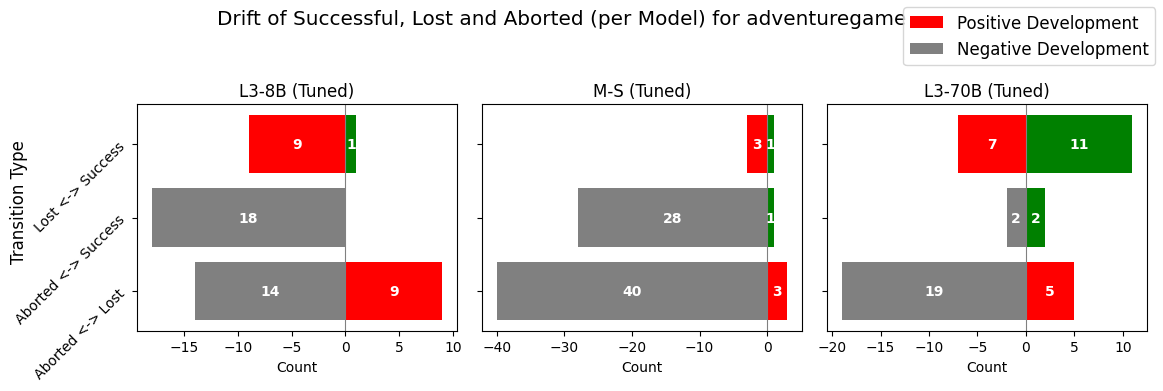

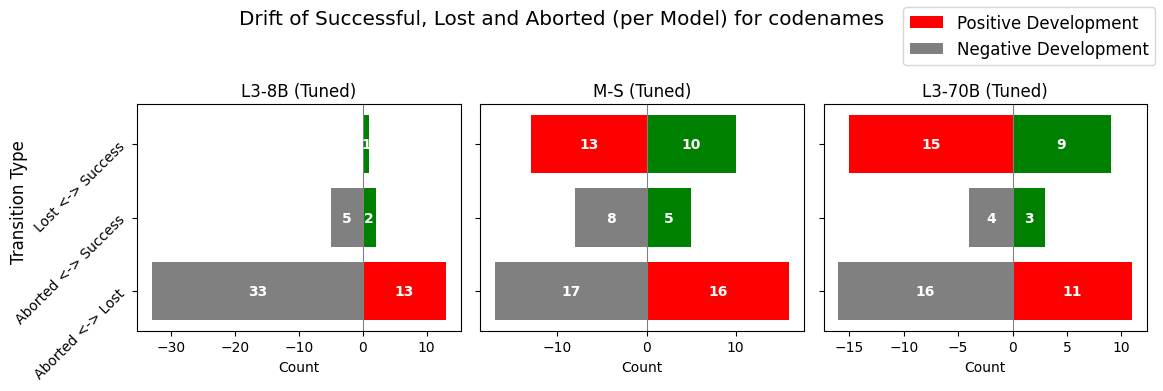

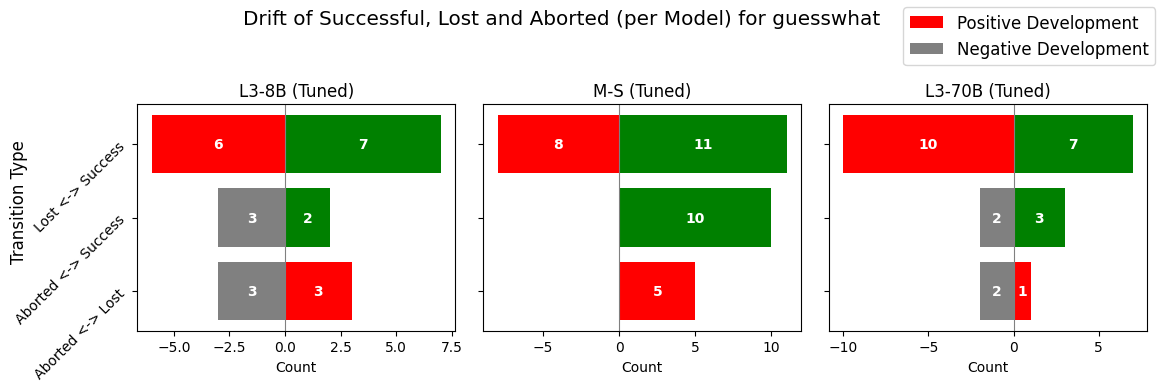

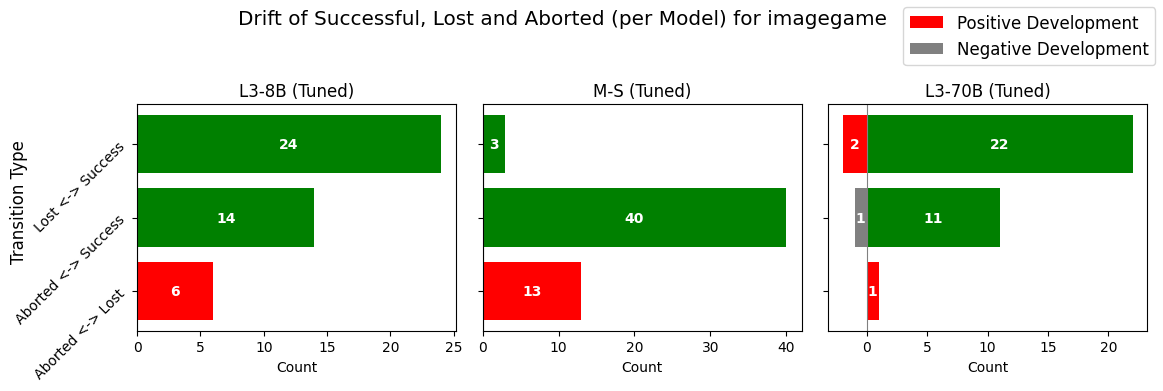

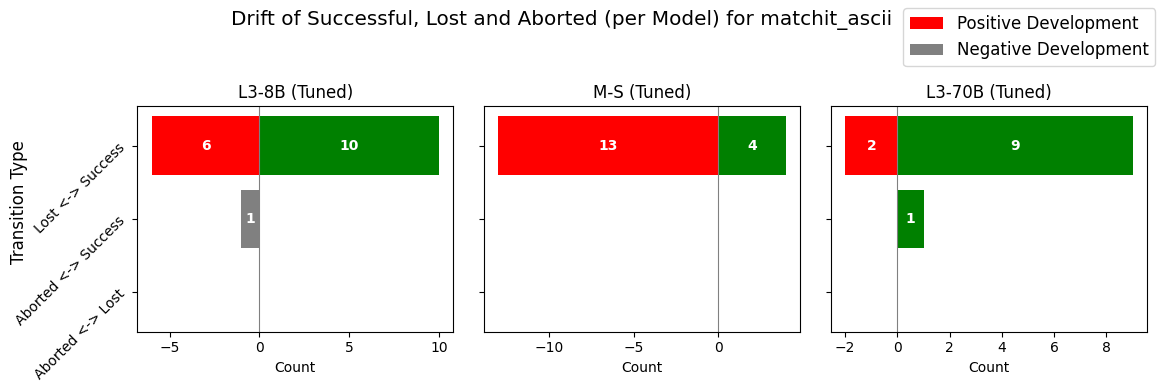

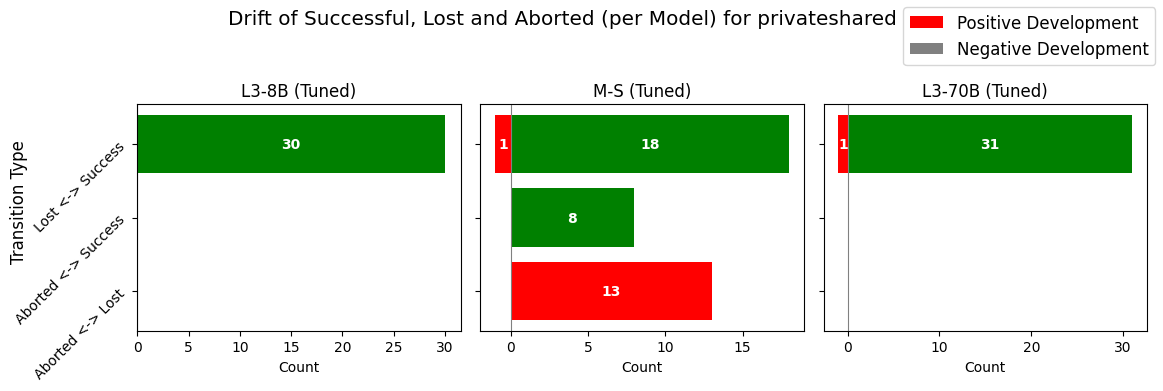

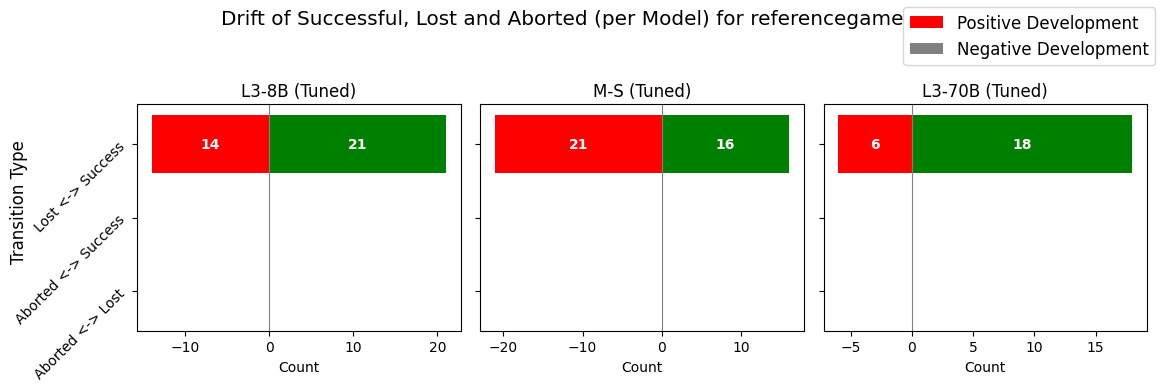

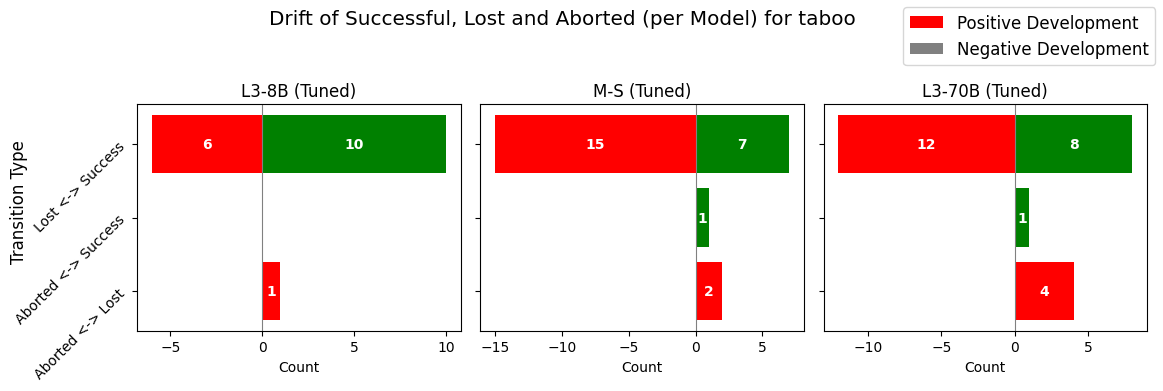

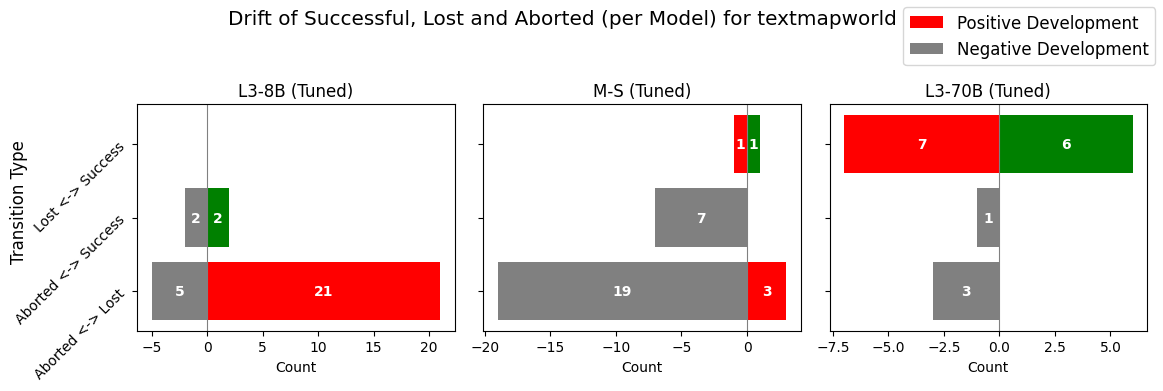

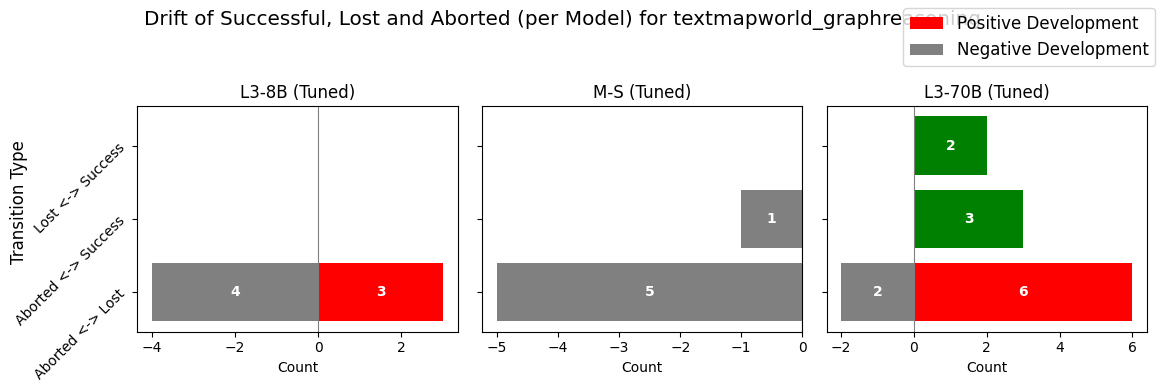

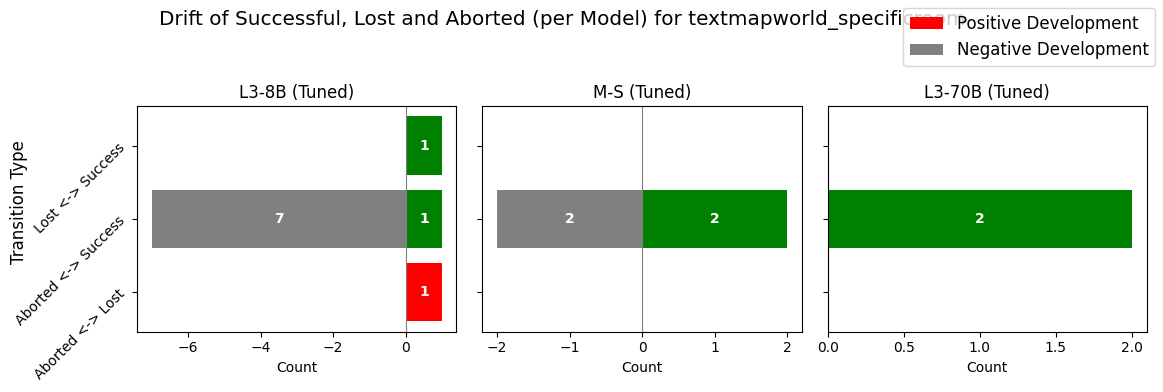

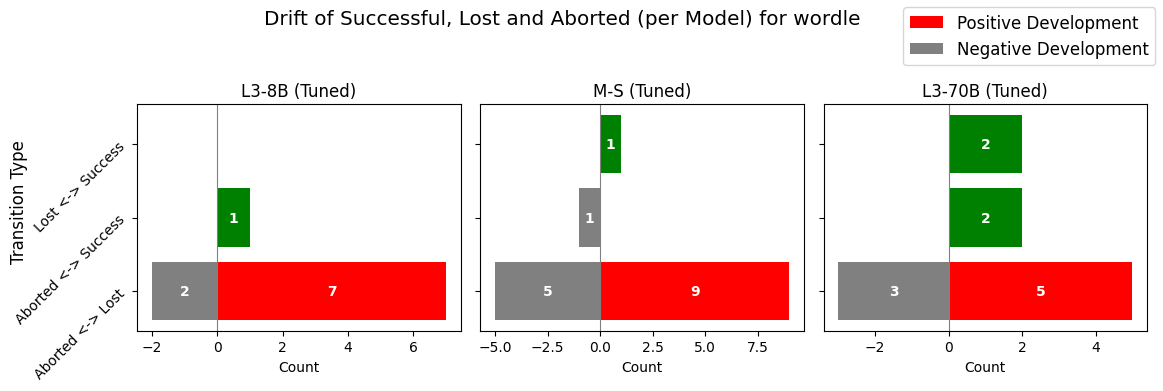

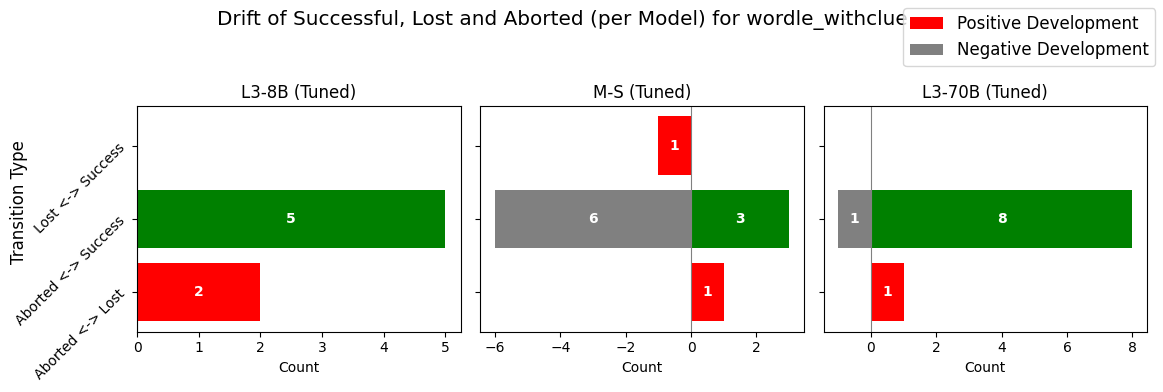

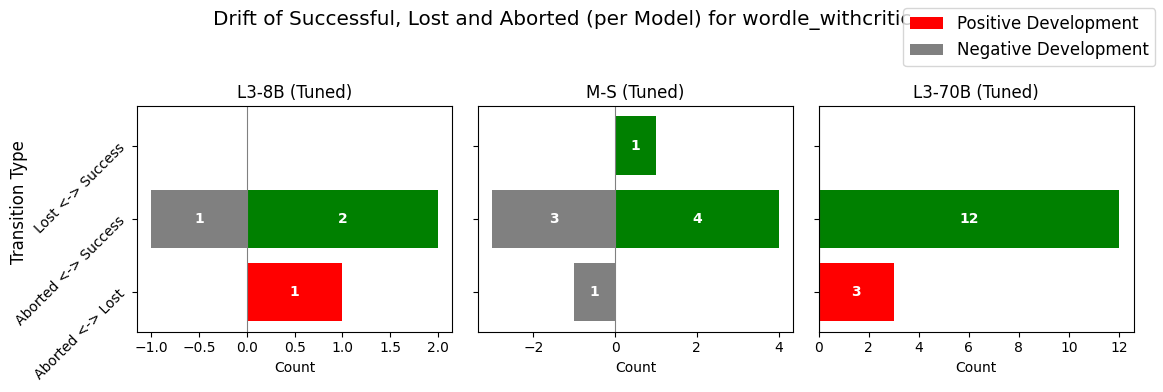

In [12]:
import matplotlib.pyplot as plt
import numpy as np

model_lookup = {
    base_model_llama_8B: final_model_llama_8B,
    base_model_mistral: final_model_mistral,
    base_model_llama_70B: final_model_llama_70B
}
for game in games:
    # Create a figure with 3 horizontal subplots
    fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

    for ax, (base_model, final_model) in zip(axes, model_lookup.items()):
        df_baseline = clean_csv_data[(clean_csv_data.model == base_model) & (clean_csv_data.game == game)].fillna(0)
        cleaned_data = clean_csv_data[(clean_csv_data.model == final_model) & (clean_csv_data.game == game)].fillna(0)

        # Apply mapping functions
        cleaned_data['lost_to_aborted'] = cleaned_data.apply(lambda x: mapLostToAborted(x, df_baseline), axis=1)
        cleaned_data['success_to_aborted'] = cleaned_data.apply(lambda x: mapSuccessToAborted(x, df_baseline), axis=1)
        cleaned_data['success_to_lost'] = cleaned_data.apply(lambda x: mapSuccessToLost(x, df_baseline), axis=1)
        cleaned_data['lost_to_success'] = cleaned_data.apply(lambda x: mapLostToSuccess(x, df_baseline), axis=1)
        cleaned_data['aborted_to_success'] = cleaned_data.apply(lambda x: mapAbortedToSuccess(x, df_baseline), axis=1)
        cleaned_data['aborted_to_lost'] = cleaned_data.apply(lambda x: mapAbortedToLost(x, df_baseline), axis=1)

        # Change model name for display
        cleaned_data.model = cleaned_data.model.apply(lambda x: map_model_name_to_simple_rep(x))

        # Filter for each transition
        lost_to_aborted = cleaned_data[(cleaned_data.lost_to_aborted == 1)]
        success_to_aborted = cleaned_data[(cleaned_data.success_to_aborted == 1)]
        success_to_loss = cleaned_data[(cleaned_data.success_to_lost == 1)]
        lost_to_success = cleaned_data[(cleaned_data.lost_to_success == 1)]
        aborted_to_success = cleaned_data[(cleaned_data.aborted_to_success == 1)]
        aborted_to_lost = cleaned_data[(cleaned_data.aborted_to_lost == 1)]

        # Data for bars
        #categories = ['Loss <-> Aborted', 'Success <-> Aborted', 'Success <-> Lost']
        categories = ['Aborted <-> Lost', 'Aborted <-> Success', 'Lost <-> Success']

        positive_values = [len(aborted_to_lost), len(aborted_to_success), len(lost_to_success)]
        negative_values = [-len(lost_to_aborted), -len(success_to_aborted), -len(success_to_loss)]

        y_pos = np.arange(len(categories))
        pos_bars = ax.barh(y_pos, positive_values, color=['r', 'g', 'g'], label='Positive Development')
        neg_bars = ax.barh(y_pos, negative_values, color=['grey', 'grey', 'r'], label='Negative Development')

        # Add value labels inside the bars
        def add_value_labels(bars):
            for bar in bars:
                width = bar.get_width()
                x_pos = width/2 if width >= 0 else width/2
                value = abs(width)
                if value == 0:
                    pass
                else:
                    ax.text(x_pos, bar.get_y() + bar.get_height()/2,
                            f'{int(value)}',
                            ha='center', va='center',
                            color='white', fontweight='bold')

        add_value_labels(pos_bars)
        add_value_labels(neg_bars)

        # Customize subplot
        ax.set_yticks(y_pos)
        if ax == axes[0]:
            ax.set_yticklabels(categories, rotation=45, ha='right')

        ax.set_xlabel('Count')
        ax.set_title(map_model_name_to_simple_rep(final_model))
        ax.axvline(0, color='grey', linewidth=0.8)

    # Add a single legend at the top center
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', ncol=1, fontsize='large')

    # Set a common y-label
    fig.text(0.04, 0.5, 'Transition Type', va='center', rotation='vertical', fontsize='large')

    # Set a common title
    fig.suptitle(f'Drift of Successful, Lost and Aborted (per Model) for {game}', fontsize='x-large')

    plt.tight_layout(rect=[0.03, 0.03, 1, 0.92])  # Leave space for legend and y-label
    plt.savefig(f'../../plots/final_plots/success_lost_abort_drift/success_lost_abort_drift_{game}.png')
    plt.show()


In [13]:
games

array(['adventuregame', 'codenames', 'guesswhat', 'imagegame',
       'matchit_ascii', 'privateshared', 'referencegame', 'taboo',
       'textmapworld', 'textmapworld_graphreasoning',
       'textmapworld_specificroom', 'wordle', 'wordle_withclue',
       'wordle_withcritic'], dtype=object)

In [84]:
cleaned_data.head()

metric,experiment,episode,game,model,Aborted,Lose,Success
0,0_home_deliver_three_basic_easy,episode_0,adventuregame,Unsloth-meta-llama-3.1-4bit-plain-t0.0--Unslot...,0.0,0.0,1.0
1,0_home_deliver_three_basic_easy,episode_1,adventuregame,Unsloth-meta-llama-3.1-4bit-plain-t0.0--Unslot...,0.0,0.0,1.0
2,0_home_deliver_three_basic_easy,episode_10,adventuregame,Unsloth-meta-llama-3.1-4bit-plain-t0.0--Unslot...,0.0,1.0,0.0
3,0_home_deliver_three_basic_easy,episode_11,adventuregame,Unsloth-meta-llama-3.1-4bit-plain-t0.0--Unslot...,0.0,1.0,0.0
4,0_home_deliver_three_basic_easy,episode_12,adventuregame,Unsloth-meta-llama-3.1-4bit-plain-t0.0--Unslot...,1.0,0.0,0.0


In [80]:
clean_csv_data.head()

metric,game,model,experiment,episode,Success,Lose,Aborted
0,adventuregame,Mistral-small-2409-DFINAL_1.7K-steps-t0.0--Mis...,0_home_deliver_three_basic_easy,episode_0,0.0,0.0,1.0
1,adventuregame,Mistral-small-2409-DFINAL_1.7K-steps-t0.0--Mis...,0_home_deliver_three_basic_easy,episode_1,0.0,0.0,1.0
2,adventuregame,Mistral-small-2409-DFINAL_1.7K-steps-t0.0--Mis...,0_home_deliver_three_basic_easy,episode_10,0.0,0.0,1.0
3,adventuregame,Mistral-small-2409-DFINAL_1.7K-steps-t0.0--Mis...,0_home_deliver_three_basic_easy,episode_11,0.0,0.0,1.0
4,adventuregame,Mistral-small-2409-DFINAL_1.7K-steps-t0.0--Mis...,0_home_deliver_three_basic_easy,episode_12,0.0,0.0,1.0


# Compute Lose Success Aborted Rate
## Create Markdown representation

In [9]:
all_games = list(clean_csv_data.game.unique())
columns_to_keep = ['game', 'model', 'Aborted', 'Lose', 'Success']
cleaned_data = clean_csv_data[columns_to_keep]
cleaned_data = cleaned_data[cleaned_data.model.isin(models_to_consider)]

In [10]:
cleaned_data.groupby(['game', 'model']).agg({'Aborted': 'sum', 'Lose': 'sum', 'Success': 'sum'})

metric                                                                Aborted  \
game              model                                                         
imagegame         Unsloth-meta-llama-3.1-4bit-plain-t0.0--Unsloth...     13.0   
                  llama3.1-sft-e1-_E1_D10001-t0.0--llama3.1-sft-e...     32.0   
                  llama3.1-sft-e1-_E1_D20001-t0.0--llama3.1-sft-e...     40.0   
                  llama3.1-sft-e1-_E1_D20002-t0.0--llama3.1-sft-e...      2.0   
                  llama3.1-sft-e1-_E1_D20003-t0.0--llama3.1-sft-e...      5.0   
...                                                                       ...   
wordle_withcritic llama3.1-sft-e1-_E1_D20003-t0.0--llama3.1-sft-e...      8.0   
                  llama3.1-sft-e1-_E1_D30001-t0.0--llama3.1-sft-e...      4.0   
                  llama3.1-sft-e1-_E1_D30002-t0.0--llama3.1-sft-e...      2.0   
                  llama3.1-sft-e1-_E1_D30003-t0.0--llama3.1-sft-e...      9.0   
                  llama3.1-sft-e1-_E1_D30004-t0.0--llama3.1-sft-e...      4.0   

metric                                                                Lose  \
game              model                                                      
imagegame         Unsloth-meta-llama-3.1-4bit-plain-t0.0--Unsloth...  27.0   
                  llama3.1-sft-e1-_E1_D10001-t0.0--llama3.1-sft-e...   7.0   
                  llama3.1-sft-e1-_E1_D20001-t0.0--llama3.1-sft-e...   0.0   
                  llama3.1-sft-e1-_E1_D20002-t0.0--llama3.1-sft-e...  31.0   
                  llama3.1-sft-e1-_E1_D20003-t0.0--llama3.1-sft-e...  31.0   
...                                                                    ...   
wordle_withcritic llama3.1-sft-e1-_E1_D20003-t0.0--llama3.1-sft-e...  16.0   
                  llama3.1-sft-e1-_E1_D30001-t0.0--llama3.1-sft-e...  18.0   
                  llama3.1-sft-e1-_E1_D30002-t0.0--llama3.1-sft-e...  23.0   
                  llama3.1-sft-e1-_E1_D30003-t0.0--llama3.1-sft-e...  14.0   
                  llama3.1-sft-e1-_E1_D30004-t0.0--llama3.1-sft-e...  21.0   

metric                                                                Success  
game              model                                                        
imagegame         Unsloth-meta-llama-3.1-4bit-plain-t0.0--Unsloth...      0.0  
                  llama3.1-sft-e1-_E1_D10001-t0.0--llama3.1-sft-e...      1.0  
                  llama3.1-sft-e1-_E1_D20001-t0.0--llama3.1-sft-e...      0.0  
                  llama3.1-sft-e1-_E1_D20002-t0.0--llama3.1-sft-e...      7.0  
                  llama3.1-sft-e1-_E1_D20003-t0.0--llama3.1-sft-e...      4.0  
...                                                                       ...  
wordle_withcritic llama3.1-sft-e1-_E1_D20003-t0.0--llama3.1-sft-e...      6.0  
                  llama3.1-sft-e1-_E1_D30001-t0.0--llama3.1-sft-e...      8.0  
                  llama3.1-sft-e1-_E1_D30002-t0.0--llama3.1-sft-e...      5.0  
                  llama3.1-sft-e1-_E1_D30003-t0.0--llama3.1-sft-e...      7.0  
                  llama3.1-sft-e1-_E1_D30004-t0.0--llama3.1-sft-e...      5.0  

[63 rows x 3 columns]

In [11]:
# Assuming you've already performed the groupby and aggregation
aggregated_data = cleaned_data.groupby(['game', 'model']).agg({'Aborted': 'sum', 'Lose': 'sum', 'Success': 'sum'})

# Calculate the total attempts for each group
aggregated_data['Total'] = aggregated_data['Aborted'] + aggregated_data['Lose'] + aggregated_data['Success']

# Calculate the ratios
aggregated_data['Success_ratio'] = (aggregated_data['Success'] / aggregated_data['Total'])*100
aggregated_data['Lose_ratio'] = (aggregated_data['Lose'] / aggregated_data['Total'])*100
aggregated_data['Aborted_ratio'] = (aggregated_data['Aborted'] / aggregated_data['Total'])*100

# Reset the index if you want 'game' and 'model' as columns
aggregated_data = aggregated_data.reset_index()

In [12]:
aggregated_data.head()

metric,game,model,Aborted,Lose,Success,Total,Success_ratio,Lose_ratio,Aborted_ratio
0,imagegame,Unsloth-meta-llama-3.1-4bit-plain-t0.0--Unslot...,13.0,27.0,0.0,40.0,0.0,67.5,32.5
1,imagegame,llama3.1-sft-e1-_E1_D10001-t0.0--llama3.1-sft-...,32.0,7.0,1.0,40.0,2.5,17.5,80.0
2,imagegame,llama3.1-sft-e1-_E1_D20001-t0.0--llama3.1-sft-...,40.0,0.0,0.0,40.0,0.0,0.0,100.0
3,imagegame,llama3.1-sft-e1-_E1_D20002-t0.0--llama3.1-sft-...,2.0,31.0,7.0,40.0,17.5,77.5,5.0
4,imagegame,llama3.1-sft-e1-_E1_D20003-t0.0--llama3.1-sft-...,5.0,31.0,4.0,40.0,10.0,77.5,12.5


In [13]:
def create_sectioned_markdown_table(df):
    # Define the model that should always be first
    first_model = 'Unsloth-meta-llama-3.1-4bit-plain-t0.0--Unsloth-meta-llama-3.1-4bit-plain-t0.0'

    # Create a custom sort order
    df['sort_order'] = df['model'].apply(lambda x: 0 if x == first_model else 1)

    # Get a consistent order for all other models
    other_models = sorted(df[df['model'] != first_model]['model'].unique())
    model_order = {model: idx + 1 for idx, model in enumerate(other_models)}

    # Apply the secondary sort order for non-first models
    df['secondary_order'] = df['model'].apply(lambda x: model_order.get(x, 0))

    # Sort the entire dataframe
    df = df.sort_values(['game', 'sort_order', 'secondary_order'])

    # Create the base header template
    header = '| Model | Success Ratio | Lose Ratio | Abort Ratio |\n|-------|---------------|------------|-------------|\n'

    # Initialize the result string
    result = []

    # Process each game separately
    for game_name, game_df in df.groupby('game'):
        result.append(f"\n## Game: {game_name}")
        result.append(header)
        rows = game_df.apply(lambda row: f'| {row.model} | {row.Success_ratio:.2f} | {row.Lose_ratio:.2f} | {row.Aborted_ratio:.2f} |',
                             axis=1).to_list()
        result.append('\n'.join(rows))

    return '\n'.join(result)
    
print(create_sectioned_markdown_table(aggregated_data))


## Game: imagegame
| Model | Success Ratio | Lose Ratio | Abort Ratio |
|-------|---------------|------------|-------------|

| Unsloth-meta-llama-3.1-4bit-plain-t0.0--Unsloth-meta-llama-3.1-4bit-plain-t0.0 | 0.00 | 67.50 | 32.50 |
| llama3.1-sft-e1-_E1_D10001-t0.0--llama3.1-sft-e1-_E1_D10001-t0.0 | 2.50 | 17.50 | 80.00 |
| llama3.1-sft-e1-_E1_D20001-t0.0--llama3.1-sft-e1-_E1_D20001-t0.0 | 0.00 | 0.00 | 100.00 |
| llama3.1-sft-e1-_E1_D20002-t0.0--llama3.1-sft-e1-_E1_D20002-t0.0 | 17.50 | 77.50 | 5.00 |
| llama3.1-sft-e1-_E1_D20003-t0.0--llama3.1-sft-e1-_E1_D20003-t0.0 | 10.00 | 77.50 | 12.50 |
| llama3.1-sft-e1-_E1_D30001-t0.0--llama3.1-sft-e1-_E1_D30001-t0.0 | 35.00 | 57.50 | 7.50 |
| llama3.1-sft-e1-_E1_D30002-t0.0--llama3.1-sft-e1-_E1_D30002-t0.0 | 25.00 | 35.00 | 40.00 |
| llama3.1-sft-e1-_E1_D30003-t0.0--llama3.1-sft-e1-_E1_D30003-t0.0 | 27.50 | 67.50 | 5.00 |
| llama3.1-sft-e1-_E1_D30004-t0.0--llama3.1-sft-e1-_E1_D30004-t0.0 | 25.00 | 72.50 | 2.50 |

## Game: privateshared
| Mod

# Analyze transitions from success to aborted or loss to aborted

In [14]:
cleaned_data = clean_csv_data[clean_csv_data.model.isin(models_to_consider)]
cleaned_data.head()

metric,game,model,experiment,episode,Aborted,Lose,Success
160,imagegame,Unsloth-meta-llama-3.1-4bit-plain-t0.0--Unslot...,0_compact_grids,episode_0,0.0,1.0,0.0
161,imagegame,Unsloth-meta-llama-3.1-4bit-plain-t0.0--Unslot...,0_compact_grids,episode_1,0.0,1.0,0.0
162,imagegame,Unsloth-meta-llama-3.1-4bit-plain-t0.0--Unslot...,0_compact_grids,episode_10,0.0,1.0,0.0
163,imagegame,Unsloth-meta-llama-3.1-4bit-plain-t0.0--Unslot...,0_compact_grids,episode_11,0.0,1.0,0.0
164,imagegame,Unsloth-meta-llama-3.1-4bit-plain-t0.0--Unslot...,0_compact_grids,episode_12,0.0,1.0,0.0


In [15]:
base_model_name: str = "Unsloth-meta-llama-3.1-4bit-plain-t0.0--Unsloth-meta-llama-3.1-4bit-plain-t0.0"

In [16]:
df_baseline = cleaned_data[cleaned_data.model == base_model_name]
def mapLostToAborted(row, baseline_df):
    game = row['game']
    experiment = row['experiment']
    episode = row['episode']

    basline_loss = baseline_df[(baseline_df['game'] == game) &
                               (baseline_df['experiment'] == experiment) &
                               (baseline_df['episode'] == episode)]['Lose'].iloc[0]  # Get the scalar value

    if basline_loss == 1 and row['Aborted'] == 1:
        return 1

    return 0

def mapSuccessToAborted(row, baseline_df):
    game = row['game']
    experiment = row['experiment']
    episode = row['episode']

    basline_loss = baseline_df[(baseline_df['game'] == game) &
                               (baseline_df['experiment'] == experiment) &
                               (baseline_df['episode'] == episode)]['Success'].iloc[0]  # Get the scalar value

    if basline_loss == 1 and row['Aborted'] == 1:
        return 1

    return 0

def mapSuccessToLost(row, baseline_df):
    game = row['game']
    experiment = row['experiment']
    episode = row['episode']

    basline_loss = baseline_df[(baseline_df['game'] == game) &
                               (baseline_df['experiment'] == experiment) &
                               (baseline_df['episode'] == episode)]['Success'].iloc[0]  # Get the scalar value

    if basline_loss == 1 and row['Lose'] == 1:
        return 1

    return 0

def mapLostToSuccess(row, baseline_df):
    game = row['game']
    experiment = row['experiment']
    episode = row['episode']

    basline_loss = baseline_df[(baseline_df['game'] == game) &
                               (baseline_df['experiment'] == experiment) &
                               (baseline_df['episode'] == episode)]['Success'].iloc[0]  # Get the scalar value

    if basline_loss == 1 and row['Success'] == 1:
        return 1

    return 0

def mapAbortedToSuccess(row, baseline_df):
    game = row['game']
    experiment = row['experiment']
    episode = row['episode']

    basline_loss = baseline_df[(baseline_df['game'] == game) &
                               (baseline_df['experiment'] == experiment) &
                               (baseline_df['episode'] == episode)]['Aborted'].iloc[0]  # Get the scalar value

    if basline_loss == 1 and row['Success'] == 1:
        return 1

    return 0

def mapAbortedToLost(row, baseline_df):
    game = row['game']
    experiment = row['experiment']
    episode = row['episode']

    basline_loss = baseline_df[(baseline_df['game'] == game) &
                               (baseline_df['experiment'] == experiment) &
                               (baseline_df['episode'] == episode)]['Aborted'].iloc[0]  # Get the scalar value

    if basline_loss == 1 and row['Lose'] == 1:
        return 1

    return 0

def map_model_name_to_simple_rep(model_name):
    if model_name == base_model_name:
        return base_model_name
    return model_name.split('_')[2].split("-")[0]
    
    

In [56]:
cleaned_data['lost_to_aborted'] = cleaned_data.apply(lambda x: mapLostToAborted(x, df_baseline), axis=1)
cleaned_data['success_to_aborted'] = cleaned_data.apply(lambda x: mapSuccessToAborted(x, df_baseline), axis=1)
cleaned_data['success_to_lost'] = cleaned_data.apply(lambda x: mapSuccessToLost(x, df_baseline), axis=1)
cleaned_data['lost_to_success'] = cleaned_data.apply(lambda x: mapLostToSuccess(x, df_baseline), axis=1)
cleaned_data['aborted_to_success'] = cleaned_data.apply(lambda x: mapAbortedToSuccess(x, df_baseline), axis=1)
cleaned_data['aborted_to_lost'] = cleaned_data.apply(lambda x: mapAbortedToLost(x, df_baseline), axis=1)

cleaned_data.model = cleaned_data.model.apply(lambda x: map_model_name_to_simple_rep(x))

/var/folders/qh/qhq087rn6n9bnym2l00z7qyw0000gn/T/ipykernel_67069/3441410459.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['lost_to_aborted'] = cleaned_data.apply(lambda x: mapLostToAborted(x, df_baseline), axis=1)
/var/folders/qh/qhq087rn6n9bnym2l00z7qyw0000gn/T/ipykernel_67069/3441410459.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['success_to_aborted'] = cleaned_data.apply(lambda x: mapSuccessToAborted(x, df_baseline), axis=1)
/var/folders/qh/qhq087rn6n9bnym2l00z7qyw

In [57]:
cleaned_data.head(120)
lost_to_aborted = cleaned_data[(cleaned_data.lost_to_aborted == 1) & (cleaned_data.model != base_model_name)]
success_to_aborted = cleaned_data[(cleaned_data.success_to_aborted == 1) & (cleaned_data.model != base_model_name)]
success_to_loss = cleaned_data[(cleaned_data.success_to_lost == 1) & (cleaned_data.model != base_model_name)]
lost_to_success = cleaned_data[(cleaned_data.lost_to_success == 1) & (cleaned_data.model != base_model_name)]
aborted_to_success = cleaned_data[(cleaned_data.aborted_to_success == 1) & (cleaned_data.model != base_model_name)]
aborted_to_lost = cleaned_data[(cleaned_data.aborted_to_lost == 1) & (cleaned_data.model != base_model_name)]

In [58]:
len(lost_to_aborted)

145

<Axes: xlabel='model'>

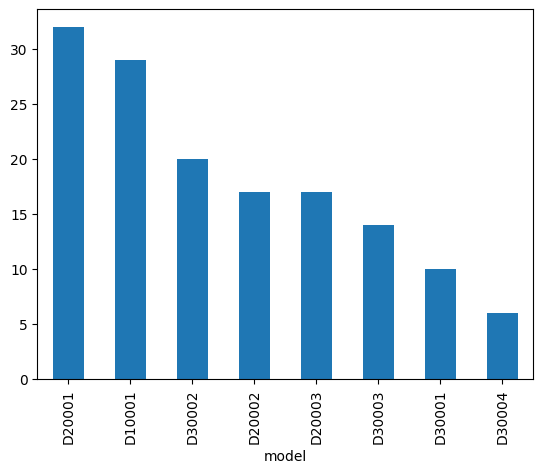

In [59]:
lost_to_aborted.model.value_counts().plot(kind='bar')

<Axes: xlabel='model'>

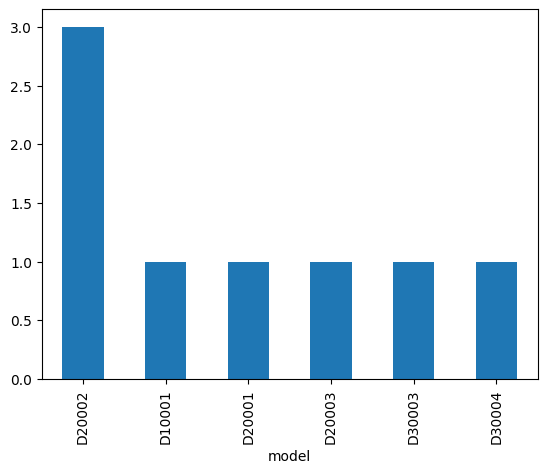

In [60]:
success_to_aborted.model.value_counts().plot(kind='bar')

<Axes: xlabel='model'>

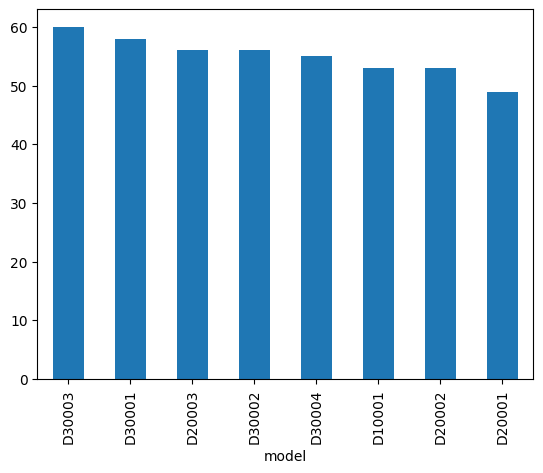

In [61]:
success_to_loss.model.value_counts().plot(kind='bar')

In [62]:
cleaned_data.columns

Index(['game', 'model', 'experiment', 'episode', 'Aborted', 'Lose', 'Success',
       'lost_to_aborted', 'success_to_aborted', 'success_to_lost',
       'lost_to_success', 'aborted_to_success', 'aborted_to_lost'],
      dtype='object', name='metric')

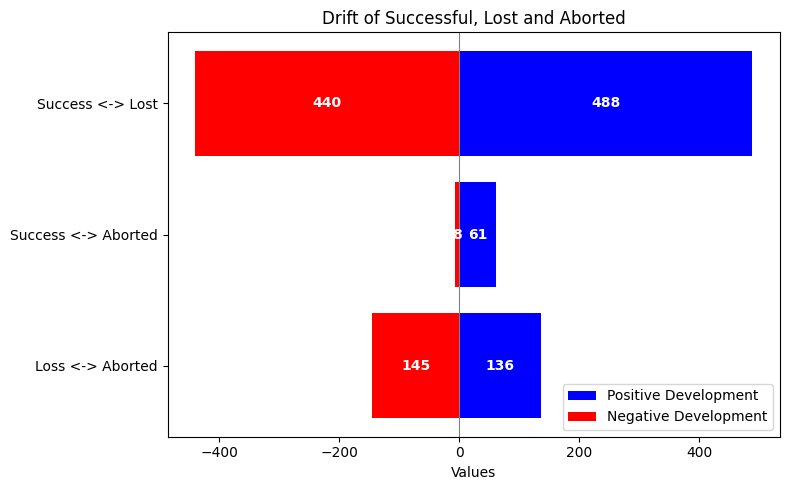

In [63]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

# Example data - replace with your actual data
categories = ['Loss <-> Aborted', 'Success <-> Aborted', 'Success <-> Lost',]
positive_values = [len(aborted_to_lost), len(aborted_to_success), len(lost_to_success)]  # your positive values
negative_values = [-len(lost_to_aborted), -len(success_to_aborted), -len(success_to_loss)]  # your negative values

# Create horizontal bars
y_pos = np.arange(len(categories))
pos_bars = ax.barh(y_pos, positive_values, color='blue', label='Positive Development')
neg_bars = ax.barh(y_pos, negative_values, color='red', label='Negative Development')

# Add value labels inside the bars
def add_value_labels(bars):
    for bar in bars:
        width = bar.get_width()
        x_pos = width/2 if width >= 0 else width/2
        # Get absolute value for display
        value = abs(width)
        ax.text(x_pos, bar.get_y() + bar.get_height()/2,
                f'{int(value)}',
                ha='center', va='center',
                color='white', fontweight='bold')

add_value_labels(pos_bars)
add_value_labels(neg_bars)

# Customize the plot
ax.set_yticks(y_pos)
ax.set_yticklabels(categories)
ax.set_xlabel('Values')
ax.set_title('Drift of Successful, Lost and Aborted')

# Add a vertical line at x=0
ax.axvline(0, color='grey', linewidth=0.8)

# Add legend
ax.legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.savefig('../../plots/diverging_success_rage.png')
plt.show()


## check clusters models that appear have issues togehter.

In [64]:
# analyze wordle games 
all_wordle_df = cleaned_data[cleaned_data.game.isin(['wordle', 'wordle_withclue', 'wordle_withcritic'])]
all_wordlle_df_with_issues = all_wordle_df[(all_wordle_df.lost_to_aborted == 1) | (all_wordle_df.success_to_lost == 1) | (all_wordle_df.success_to_aborted == 1)]

res_df = all_wordlle_df_with_issues.drop(['Aborted', 'Lose', 'Success',
                                 'lost_to_aborted', 'success_to_aborted', 'success_to_lost',
                                 'lost_to_success', 'aborted_to_success', 'aborted_to_lost'], axis=1)

In [65]:
len(all_wordlle_df_with_issues)

94

In [66]:
groups = res_df.groupby(['game', 'experiment', 'episode', 'model'])

In [67]:
groups.first()

Empty DataFrame
Columns: []
Index: [(wordle, 0_high_frequency_words_no_clue_no_critic, episode_1, D20002), (wordle, 0_high_frequency_words_no_clue_no_critic, episode_1, D20003), (wordle, 0_high_frequency_words_no_clue_no_critic, episode_3, D10001), (wordle, 0_high_frequency_words_no_clue_no_critic, episode_3, D20001), (wordle, 0_high_frequency_words_no_clue_no_critic, episode_3, D30003), (wordle, 0_high_frequency_words_no_clue_no_critic, episode_5, D10001), (wordle, 1_medium_frequency_words_no_clue_no_critic, episode_1, D30001), (wordle, 1_medium_frequency_words_no_clue_no_critic, episode_14, D20002), (wordle, 1_medium_frequency_words_no_clue_no_critic, episode_14, D20003), (wordle, 1_medium_frequency_words_no_clue_no_critic, episode_15, D30003), (wordle, 1_medium_frequency_words_no_clue_no_critic, episode_17, D30003), (wordle, 1_medium_frequency_words_no_clue_no_critic, episode_6, D30003), (wordle, 1_medium_frequency_words_no_clue_no_critic, episode_7, D20003), (wordle, 1_medium_frequency_words_no_clue_no_critic, episode_8, D20001), (wordle, 1_medium_frequency_words_no_clue_no_critic, episode_8, D20002), (wordle, 1_medium_frequency_words_no_clue_no_critic, episode_9, D30003), (wordle_withclue, 0_high_frequency_words_clue_no_critic, episode_0, D10001), (wordle_withclue, 0_high_frequency_words_clue_no_critic, episode_0, D30001), (wordle_withclue, 0_high_frequency_words_clue_no_critic, episode_0, D30002), (wordle_withclue, 0_high_frequency_words_clue_no_critic, episode_5, D30001), (wordle_withclue, 0_high_frequency_words_clue_no_critic, episode_7, D30004), (wordle_withclue, 1_medium_frequency_words_clue_no_critic, episode_10, D20002), (wordle_withclue, 1_medium_frequency_words_clue_no_critic, episode_10, D20003), (wordle_withclue, 1_medium_frequency_words_clue_no_critic, episode_11, D20002), (wordle_withclue, 1_medium_frequency_words_clue_no_critic, episode_12, D20002), (wordle_withclue, 1_medium_frequency_words_clue_no_critic, episode_12, D30003), (wordle_withclue, 1_medium_frequency_words_clue_no_critic, episode_13, D10001), (wordle_withclue, 1_medium_frequency_words_clue_no_critic, episode_13, D20001), (wordle_withclue, 1_medium_frequency_words_clue_no_critic, episode_13, D30004), (wordle_withclue, 1_medium_frequency_words_clue_no_critic, episode_14, D20002), (wordle_withclue, 1_medium_frequency_words_clue_no_critic, episode_14, D20003), (wordle_withclue, 1_medium_frequency_words_clue_no_critic, episode_15, D20002), (wordle_withclue, 1_medium_frequency_words_clue_no_critic, episode_16, D20003), (wordle_withclue, 1_medium_frequency_words_clue_no_critic, episode_17, D20003), (wordle_withclue, 1_medium_frequency_words_clue_no_critic, episode_17, D30003), (wordle_withclue, 1_medium_frequency_words_clue_no_critic, episode_18, D10001), (wordle_withclue, 1_medium_frequency_words_clue_no_critic, episode_18, D20001), (wordle_withclue, 1_medium_frequency_words_clue_no_critic, episode_18, D20002), (wordle_withclue, 1_medium_frequency_words_clue_no_critic, episode_18, D20003), (wordle_withclue, 1_medium_frequency_words_clue_no_critic, episode_18, D30001), (wordle_withclue, 1_medium_frequency_words_clue_no_critic, episode_18, D30002), (wordle_withclue, 1_medium_frequency_words_clue_no_critic, episode_18, D30003), (wordle_withclue, 1_medium_frequency_words_clue_no_critic, episode_19, D20001), (wordle_withclue, 1_medium_frequency_words_clue_no_critic, episode_19, D30004), (wordle_withclue, 1_medium_frequency_words_clue_no_critic, episode_4, D20002), (wordle_withclue, 1_medium_frequency_words_clue_no_critic, episode_4, D20003), (wordle_withclue, 1_medium_frequency_words_clue_no_critic, episode_4, D30001), (wordle_withclue, 1_medium_frequency_words_clue_no_critic, episode_4, D30003), (wordle_withclue, 1_medium_frequency_words_clue_no_critic, episode_5, D30001), (wordle_withclue, 1_medium_frequency_words_clue_no_critic, episode_5, D30002), (wordle_withclue, 1_medium_frequency_words_clue_no_critic, episode_5, D30003), (wordle_withclue, 1_medium

In [68]:
all_groups = groups.groups

In [69]:
collected_results = {}
for g, i in all_groups.items():
    key = f'{g[0]}-{g[1]}-{g[2]}'
    if key in collected_results:
        collected_results[key].append(g[3])
    else:
        collected_results[key] = [g[3]]

In [70]:
transformed_results = {}
for key in collected_results:
    content = key.split('-')
    content.append(collected_results[key])
    transformed_results[key] = content

In [71]:
aggregated_df = pd.DataFrame.from_dict(transformed_results, orient="index")

In [72]:
def map_experimet_name(name):
    if name.startswith('0_'):
        return '0_high_freq'
    else:
        return '1_med_freq'
    
aggregated_df[1] = aggregated_df[1].map(map_experimet_name)

In [73]:
aggregated_df.rename(columns={0:"game", 1:"experiment", 2:"episode", 3:"model"}, inplace=True)
aggregated_df.sort_values(by=['experiment', 'episode'], inplace=True)


In [74]:
high_freq = aggregated_df[aggregated_df.experiment.str.contains('0_high_freq')]
med_freq  = aggregated_df[aggregated_df.experiment.str.contains('1_')]

In [75]:
med_freq.sort_values(by=['episode'], inplace=True)
med_freq.head(100)

/var/folders/qh/qhq087rn6n9bnym2l00z7qyw0000gn/T/ipykernel_67069/2357715957.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  med_freq.sort_values(by=['episode'], inplace=True)


,game,experiment,episode,model
wordle_withcritic-1_medium_frequency_words_clue_with_critic-episode_0,wordle_withcritic,1_med_freq,episode_0,"[D10001, D20001, D20002, D20003, D30001, D3000..."
wordle-1_medium_frequency_words_no_clue_no_critic-episode_1,wordle,1_med_freq,episode_1,[D30001]
wordle_withcritic-1_medium_frequency_words_clue_with_critic-episode_1,wordle_withcritic,1_med_freq,episode_1,[D30003]
wordle_withclue-1_medium_frequency_words_clue_no_critic-episode_10,wordle_withclue,1_med_freq,episode_10,"[D20002, D20003]"
wordle_withcritic-1_medium_frequency_words_clue_with_critic-episode_10,wordle_withcritic,1_med_freq,episode_10,"[D20002, D20003]"
wordle_withclue-1_medium_frequency_words_clue_no_critic-episode_11,wordle_withclue,1_med_freq,episode_11,[D20002]
wordle_withclue-1_medium_frequency_words_clue_no_critic-episode_12,wordle_withclue,1_med_freq,episode_12,"[D20002, D30003]"
wordle_withcritic-1_medium_frequency_words_clue_with_critic-episode_12,wordle_withcritic,1_med_freq,episode_12,"[D10001, D20002, D20003, D30002]"
wordle_withclue-1_medium_frequency_words_clue_no_critic-episode_13,wordle_withclue,1_med_freq,episode_13,"[D10001, D20001, D30004]"
wordle-1_medium_frequency_words_no_clue_no_critic-episode_14,wordle,1_med_freq,episode_14,"[D20002, D20003]"


1_medium_frequency_words_clue_with_critic,episode_10 D20002 INVALID_WORD_LENGTH,     D20003 INVALID_WORD_LENGTH
1_medium_frequency_words_clue_no_critic,episode_10,  D20002 INVALID_WORD_LENGTH      D20003 NOT_VALID_ENGLISH_WORD

1_medium_frequency_words_clue_with_critic,episode_12 D20002





In [76]:
high_freq.sort_values(by=['episode'], inplace=True)
high_freq.head(100)

/var/folders/qh/qhq087rn6n9bnym2l00z7qyw0000gn/T/ipykernel_67069/1915523180.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_freq.sort_values(by=['episode'], inplace=True)


,game,experiment,episode,model
wordle_withclue-0_high_frequency_words_clue_no_critic-episode_0,wordle_withclue,0_high_freq,episode_0,"[D10001, D30001, D30002]"
wordle-0_high_frequency_words_no_clue_no_critic-episode_1,wordle,0_high_freq,episode_1,"[D20002, D20003]"
wordle_withcritic-0_high_frequency_words_clue_with_critic-episode_1,wordle_withcritic,0_high_freq,episode_1,"[D20002, D30003]"
wordle-0_high_frequency_words_no_clue_no_critic-episode_3,wordle,0_high_freq,episode_3,"[D10001, D20001, D30003]"
wordle_withcritic-0_high_frequency_words_clue_with_critic-episode_3,wordle_withcritic,0_high_freq,episode_3,"[D20001, D20002, D20003]"
wordle-0_high_frequency_words_no_clue_no_critic-episode_5,wordle,0_high_freq,episode_5,[D10001]
wordle_withclue-0_high_frequency_words_clue_no_critic-episode_5,wordle_withclue,0_high_freq,episode_5,[D30001]
wordle_withclue-0_high_frequency_words_clue_no_critic-episode_7,wordle_withclue,0_high_freq,episode_7,[D30004]
wordle_withcritic-0_high_frequency_words_clue_with_critic-episode_7,wordle_withcritic,0_high_freq,episode_7,[D30003]
wordle_withcritic-0_high_frequency_words_clue_with_critic-episode_9,wordle_withcritic,0_high_freq,episode_9,"[D30002, D30003, D30004]"


# findings

### 1 medium freq
there is a connection that when a model has a regression in one particular word in wordle, it is likely to also fail with that word in the other versions
in two cases the mode failed in all three versions.

### 2 high freq
same connection but can be extended towards the experiment line

In [77]:
def prepare_instance_data(path: str) -> dict:
    with open(path, 'r') as f:
        data: dict = json.load(f)
        return data

In [93]:
maping = {
    'wordle_0_high_freq': '0_high_frequency_words_no_clue_no_critic',
    'wordle_1_med_freq': '1_medium_frequency_words_no_clue_no_critic',
    'wordle_withclue_0_high_freq': '0_high_frequency_words_clue_no_critic',
    'wordle_withclue_1_med_freq': '1_medium_frequency_words_clue_no_critic',
    'wordle_withcritic_0_high_freq': '0_high_frequency_words_clue_with_critic',
    'wordle_withcritic_1_med_freq': '1_medium_frequency_words_clue_with_critic',
}

def find_error_reason(row):
    models = row['model']
    final_game_state = []
    reason = []
    for model in models:
        real_name: str = f'llama3.1-sft-e1-_E1_{model}-t0.0--llama3.1-sft-e1-_E1_{model}-t0.0'
        exp = maping[row['game']+"_"+row['experiment']] 
        path: str = f"../../benchmark_results/{real_name}/{row['game']}/{exp}/{row['episode']}/interactions.json"
        data = prepare_instance_data(path)
        final_game_state.append(data['turns'][-1][-1]['action']['data_for_computation']['game_final_status'])
        reason.append(data['turns'][-1][-1]['action']['data_for_computation']['guesser_error'])
    return reason
        
med_freq["reason"] = med_freq.apply(find_error_reason, axis=1)

/var/folders/qh/qhq087rn6n9bnym2l00z7qyw0000gn/T/ipykernel_67069/528690351.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  med_freq["reason"] = med_freq.apply(find_error_reason, axis=1)


In [94]:
med_freq.head(100)

,game,experiment,episode,model,reason
wordle_withcritic-1_medium_frequency_words_clue_with_critic-episode_0,wordle_withcritic,1_med_freq,episode_0,"[D10001, D20001, D20002, D20003, D30001, D3000...","[None, None, NOT_VALID_ENGLISH_WORD, None, Non..."
wordle-1_medium_frequency_words_no_clue_no_critic-episode_1,wordle,1_med_freq,episode_1,[D30001],[NOT_VALID_ENGLISH_WORD]
wordle_withcritic-1_medium_frequency_words_clue_with_critic-episode_1,wordle_withcritic,1_med_freq,episode_1,[D30003],[NOT_VALID_ENGLISH_WORD]
wordle_withclue-1_medium_frequency_words_clue_no_critic-episode_10,wordle_withclue,1_med_freq,episode_10,"[D20002, D20003]","[INVALID_WORD_LENGTH, NOT_VALID_ENGLISH_WORD]"
wordle_withcritic-1_medium_frequency_words_clue_with_critic-episode_10,wordle_withcritic,1_med_freq,episode_10,"[D20002, D20003]","[INVALID_WORD_LENGTH, INVALID_WORD_LENGTH]"
wordle_withclue-1_medium_frequency_words_clue_no_critic-episode_11,wordle_withclue,1_med_freq,episode_11,[D20002],[INVALID_WORD_LENGTH]
wordle_withclue-1_medium_frequency_words_clue_no_critic-episode_12,wordle_withclue,1_med_freq,episode_12,"[D20002, D30003]","[NOT_VALID_ENGLISH_WORD, INVALID_WORD_LENGTH]"
wordle_withcritic-1_medium_frequency_words_clue_with_critic-episode_12,wordle_withcritic,1_med_freq,episode_12,"[D10001, D20002, D20003, D30002]","[NOT_VALID_ENGLISH_WORD, INVALID_WORD_LENGTH, ..."
wordle_withclue-1_medium_frequency_words_clue_no_critic-episode_13,wordle_withclue,1_med_freq,episode_13,"[D10001, D20001, D30004]","[INVALID_WORD_LENGTH, INVALID_WORD_LENGTH, INV..."
wordle-1_medium_frequency_words_no_clue_no_critic-episode_14,wordle,1_med_freq,episode_14,"[D20002, D20003]","[NOT_VALID_ENGLISH_WORD, INVALID_WORD_LENGTH]"


In [95]:
# check out errors per game

wordle_withclue = []
wordle_withcritic = []

for i, row in med_freq.iterrows():
    if row['game'] == "wordle_withclue":
        wordle_withclue.extend(row['reason'])
    elif row['game'] == "wordle_withcritic":
        wordle_withcritic.extend(row['reason'])

In [99]:
all_reasons = list(set(wordle_withclue))
for reason in all_reasons:
    count = wordle_withclue.count(reason)
    print(f'{reason}: {count}')

None: 13
INVALID_WORD: 1
INVALID_WORD_LENGTH: 18
NOT_VALID_ENGLISH_WORD: 7


In [100]:
all_reasons = list(set(wordle_withcritic))
for reason in all_reasons:
    count = wordle_withcritic.count(reason)
    print(f'{reason}: {count}')

INVALID_WORD_LENGTH: 10
None: 9
NOT_VALID_ENGLISH_WORD: 6
